# Creating a model for gender recognition with MLlib


*   Input for the model will be  an image of a man or a woman.
*   Output of the model will  a boolean: women or men.

To train our model (s) we will use a dataset of 948MB from this Kaggle link:

*   https://www.kaggle.com/datasets/humairmunir/gender-recognizer

This dataset contains two folders, each one respectively containing 646 images of women and men.

The objective of this project will not be to create the most powerful model possible, as a CNN would be a much better option for image classification than a model from MLlib. Since I only know CNNs for class prediction on images, and the other models available in MLlib, like LogisticRegression or RandomForestClassifier, are not even designed for image processing, it is in contexts like this that data mining becomes especially important. We will need to thoroughly understand the dataset to manually identify patterns, such as the presence of certain colors or color variance (this non-intuitive aspect will be explained later on).

But first, let's start by configuring our environment and preparing the data for processing.


INITIALIZE A BASIC SPARK SESSION, with the  code view in class:

# Why do we use Spark (in big data context) ?

*   Spark is used in big data because it enables fast, scalable processing across distributed clusters by dividing data and tasks among multiple computers. If one computer fails, Spark automatically redistributes the tasks, ensuring fault tolerance. With this architecture, multiple computers work together on the same problem, allowing efficient handling of massive datasets and various workloads, such as batch processing, real-time streaming, and machine learning.
*   However we will not be using multiples computers for processing because it is a relatively small project, one is enough, the point of using this technology is more showing that I know why I use it and how to use it.


# Why are we talking about big data ?

*   The five elements (the famous 5Vs) that make data BigData:

    1.   Volume:  As already anounced, our dataset weighs a little big less than one GB, so in that aspect we are talking of big data.
    2.   Value:  The value of a dig data comes from the discovery of pertinent information. We will see later on that we discover some patterns in our image set.
    3.   Variety: our data does not really come from a large variety of sources, we got a pretreated dataset. But in an aspect there was a variety problem for the creator, because each picture comes from a different source, from a different person who took a selfy before sending it.
    4.   Velocity: in this aspect we're not talking about big data because our model will never be deploid, and we do not need it to be fast/veloce, or to process images instantly.
    5.   Veracity: Here we speak about veracity because the images has been verified/certified to be "true", by kaggle, who puts the score of 8.75, but 100% in the category of "credibility". (The final grade of the set was'nt of 10/10 because the images were not not containing "file Description")









In [ ]:
#Bibliotecas para poder trabajar con Spark
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.4.4//spark-3.4.4-bin-hadoop3.tgz
!tar xf spark-3.4.4-bin-hadoop3.tgz
#Configuración de Spark con Python
!pip install -q findspark
!pip install pyspark

#Estableciendo variable de entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.4-bin-hadoop3"

#Buscando e inicializando la instalación de Spark
import findspark
findspark.init()
findspark.find()

#Probando PySparl
from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark = SparkSession \
       .builder \
       .appName("Hola mundo Spark") \
       .getOrCreate()

spark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,110 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,615 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-s

MOUNT TO MY GDRIVE, WHERE MY DATABASE IS STORED. This way I can access the dataset present in my google drive account from this Google collab session.

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")
!pwd

Mounted at /content/gdrive
/content


This is what our folders contain. This is a view of our aldready separated train/men folder.

In [ ]:
!ls /content/gdrive/MyDrive/abalone/archive_Gender/train/men


0.jpg	 109.jpg  19.jpg  28.jpg  37.jpg  46.jpg  55.jpg  64.jpg  73.jpg  82.jpg  91.jpg
100.jpg  10.jpg   1.jpg   29.jpg  38.jpg  47.jpg  56.jpg  65.jpg  74.jpg  83.jpg  92.jpg
101.jpg  11.jpg   20.jpg  2.jpg   39.jpg  48.jpg  57.jpg  66.jpg  75.jpg  84.jpg  93.jpg
102.jpg  12.jpg   21.jpg  30.jpg  3.jpg   49.jpg  58.jpg  67.jpg  76.jpg  85.jpg  94.jpg
103.jpg  13.jpg   22.jpg  31.jpg  40.jpg  4.jpg   59.jpg  68.jpg  77.jpg  86.jpg  95.jpg
104.jpg  14.jpg   23.jpg  32.jpg  41.jpg  50.jpg  5.jpg   69.jpg  78.jpg  87.jpg  96.jpg
105.jpg  15.jpg   24.jpg  33.jpg  42.jpg  51.jpg  60.jpg  6.jpg   79.jpg  88.jpg  97.jpg
106.jpg  16.jpg   25.jpg  34.jpg  43.jpg  52.jpg  61.jpg  70.jpg  7.jpg   89.jpg  98.jpg
107.jpg  17.jpg   26.jpg  35.jpg  44.jpg  53.jpg  62.jpg  71.jpg  80.jpg  8.jpg   99.jpg
108.jpg  18.jpg   27.jpg  36.jpg  45.jpg  54.jpg  63.jpg  72.jpg  81.jpg  90.jpg  9.jpg


An important library specialised on images operations.

In [ ]:
!pip install pillow


#Preparing the Data:

Here, I load the images and transform them (in the "load_image" function). These are the steps of the transformation:

  Crop the image by removing 200 pixels from each side (left, top, right, and bottom).
  Resize the cropped image to 200 pixels by 200 pixels.

Explanation of this decision:
The goal of creating an AI for gender recognition is to go beyond stereotypes. This is why I prioritize the size, quality, and details of the images: I want to ensure the model learns morphological patterns rather than superficial ones, like red lips.

  After cropping and resizing, I convert the image into a one-dimensional numpy array using the "flatten" function.
  Finally, I transform this array into a "DenseVector," making the data ready for use in an MLlib model.

These steps would have been the same if we were using a CNN.

In [ ]:
import os
from PIL import Image
import numpy as np
from pyspark.sql import Row
from pyspark.ml.linalg import DenseVector

# Fonction pour charger une image, couper les bords, convertir en niveaux de gris, et redimensionner
def load_image(path):
    img = Image.open(path)  # Charger l'image originale

    # Vérifier les dimensions de l'image
    width, height = img.size
    margin = 10  # Nombre de pixels à supprimer de chaque côté

    if width <= 2 * margin or height <= 2 * margin:
        raise ValueError(f"L'image {path} est trop petite pour être découpée avec une marge de {margin}px.")

    # Calculer les nouvelles coordonnées
    left = margin
    top = margin
    right = width - margin
    bottom = height - margin

    # Couper l'image (crop) pour enlever les pixels du bord
    img = img.crop((left, top, right, bottom))

    # Convertir l'image en niveaux de gris
    img = img.convert('L')

    # Redimensionner l'image à 200x200
    img = img.resize((200, 200))

    # Convertir en tableau NumPy et aplatir (flatten) en vecteur 1D
    img_array = np.array(img).flatten()

    # Retourner le vecteur sous forme de DenseVector pour Spark
    return DenseVector(img_array)

# Fonction pour charger les images d'un dossier et les associer à une étiquette
def load_images_from_folder(folder, label):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            try:
                img_vector = load_image(img_path)  # Utiliser la nouvelle fonction load_image
                images.append(Row(features=img_vector, label=label))
            except ValueError as e:
                print(e)  # Afficher un message d'erreur et passer à l'image suivante
    return images

# Charger les images d'entraînement du dossier 'train/men' avec l'étiquette 0
train_men_images = load_images_from_folder('/content/gdrive/MyDrive/GenderIsmael/output/train/MEN', 0)

# Charger les images d'entraînement du dossier 'train/women' avec l'étiquette 1
train_women_images = load_images_from_folder('/content/gdrive/MyDrive/GenderIsmael/output/train/WOMAN', 1)

# Créer un DataFrame Spark pour l'entraînement
train_data = spark.createDataFrame(train_men_images + train_women_images)

# Charger les images de test du dossier 'test/men' avec l'étiquette 0
test_men_images = load_images_from_folder('/content/gdrive/MyDrive/GenderIsmael/output/test/MEN', 0)

# Charger les images de test du dossier 'test/women' avec l'étiquette 1
test_women_images = load_images_from_folder('/content/gdrive/MyDrive/GenderIsmael/output/test/WOMAN', 1)

# Créer un DataFrame Spark pour le test
test_data = spark.createDataFrame(test_men_images + test_women_images)

# Afficher la structure des DataFrames d'entraînement et de test
train_data.show(5)
test_data.show(5)


+--------------------+-----+
|            features|label|
+--------------------+-----+
|[86.0,87.0,84.0,8...|    0|
|[254.0,254.0,254....|    0|
|[165.0,167.0,165....|    0|
|[222.0,221.0,223....|    0|
|[191.0,184.0,196....|    0|
+--------------------+-----+
only showing top 5 rows

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[218.0,218.0,219....|    0|
|[61.0,61.0,61.0,6...|    0|
|[101.0,100.0,100....|    0|
|[188.0,191.0,191....|    0|
|[146.0,147.0,149....|    0|
+--------------------+-----+
only showing top 5 rows



Just for having an idea of what transformation we did to our images, here are two pictures printed after the data augmentation, and before the vectorisation, afet the vectorisation it will just be arrays of numbers.

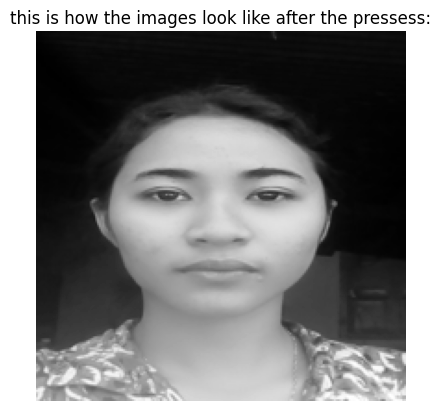

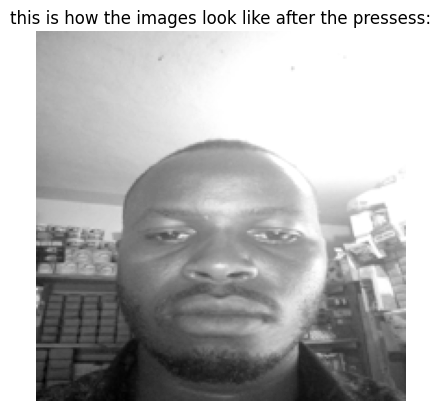

array([158, 162, 157, ..., 100, 108, 104], dtype=uint8)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Fonction pour charger une image, couper les bords, convertir en niveaux de gris, redimensionner et afficher l'image
def load_image(path):
    img = Image.open(path)  # Charger l'image originale

    # Supprimer 200 pixels de chaque côté (haut, bas, gauche, droite)
    width, height = img.size
    left = 10
    top = 10
    right = width - 10
    bottom = height - 10

    # Couper l'image (crop) pour enlever les pixels du bord
    img = img.crop((left, top, right, bottom))

    # Convertir l'image en niveaux de gris
    img = img.convert('L')

    # Redimensionner l'image à 200x200
    img = img.resize((200, 200))

    # Afficher l'image transformée
    plt.imshow(img, cmap='gray')
    plt.title("this is how the images look like after the process:")
    plt.axis('off')  # Cacher les axes
    plt.show()

    # Convertir en tableau NumPy et aplatir (flatten) en vecteur 1D
    img_array = np.array(img).flatten()

    # Retourner le vecteur sous forme de DenseVector pour Spark
    return img_array  # Retourne le tableau mais cela n'est pas affiché ici

# Appel pour afficher une image transformée
load_image('/content/gdrive/MyDrive/GenderIsmael/output/train/MEN/20240705_123756.jpg')  # Remplacer par le chemin correct de ton image
load_image('/content/gdrive/MyDrive/GenderIsmael/output/train/MEN/20240609_182358.jpg')  # Remplacer par le chemin correct de ton image



Let's create our first model: a LogisticRegression, it should be pretty bad because it is really not done for data processing, as it does not contain convolutional layers, and so is really bad in recognition of patterns in a 2D space.

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Créer le modèle de régression logistique
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=40)

# Entraîner le modèle sur le dataset d'entraînement
print("Entraînement du modèle...")
model = lr.fit(train_data)
print("Modèle entraîné.")

# Faire des prédictions sur le dataset de test
predictions = model.transform(test_data)

# Afficher quelques prédictions
predictions.select('features', 'label', 'prediction').show(5)

# Évaluer le modèle en calculant l'accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy}")


Entraînement du modèle...
Modèle entraîné.
+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[218.0,218.0,219....|    0|       1.0|
|[61.0,61.0,61.0,6...|    0|       1.0|
|[101.0,100.0,100....|    0|       1.0|
|[188.0,191.0,191....|    0|       1.0|
|[146.0,147.0,149....|    0|       0.0|
+--------------------+-----+----------+
only showing top 5 rows

Accuracy: 0.475


As predicted our model is really really bad (47.5%), it is worst than the hasard, if we predict all men or all women the score would be better: 50%.

Now we will use a RandomForestClassifier, this model is more complex and should get more details but isn't also for image processing, a CNNs would lot more performing.

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Créer le modèle Random Forest
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=90, maxDepth=12)

# Entraîner le modèle sur le dataset d'entraînement
print("Entraînement du modèle Random Forest...")
rf_model = rf.fit(train_data)
print("Modèle Random Forest entraîné.")

# Faire des prédictions sur le dataset de test
predictions = rf_model.transform(test_data)

# Afficher quelques prédictions
predictions.select('features', 'label', 'prediction').show(5)

# Évaluer le modèle en calculant l'accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Random Forest Accuracy: {accuracy}")


Entraînement du modèle Random Forest...
Modèle Random Forest entraîné.
+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[218.0,218.0,219....|    0|       0.0|
|[61.0,61.0,61.0,6...|    0|       0.0|
|[101.0,100.0,100....|    0|       0.0|
|[188.0,191.0,191....|    0|       0.0|
|[146.0,147.0,149....|    0|       1.0|
+--------------------+-----+----------+
only showing top 5 rows

Random Forest Accuracy: 0.6125


With an accuracy of 0.6125 on a binary class regression it is again really bad. We have to find a way to get more patterns. A model like those ones is not the more appropriate method. This Random forest got more details than I was expencting, it did 12,5% better than hasard. I tried also with more trees and/or more depth, but the problem is as this model is by nature not performant with images/vectors, it will just momorize the training data and get zero patterns (this problem is called overfitting).

Entraînement du modèle Random Forest...
Modèle Random Forest entraîné.
+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[218.0,218.0,219....|    0|       0.0|
|[61.0,61.0,61.0,6...|    0|       0.0|
|[101.0,100.0,100....|    0|       0.0|
|[188.0,191.0,191....|    0|       0.0|
|[146.0,147.0,149....|    0|       1.0|
+--------------------+-----+----------+
only showing top 5 rows

Accuracy: 0.6125
F1-Score: 0.6119543107494914
Précision: 0.6131363922061597
Rappel: 0.6125
Matrice de confusion :
[[26 14]
 [17 23]]


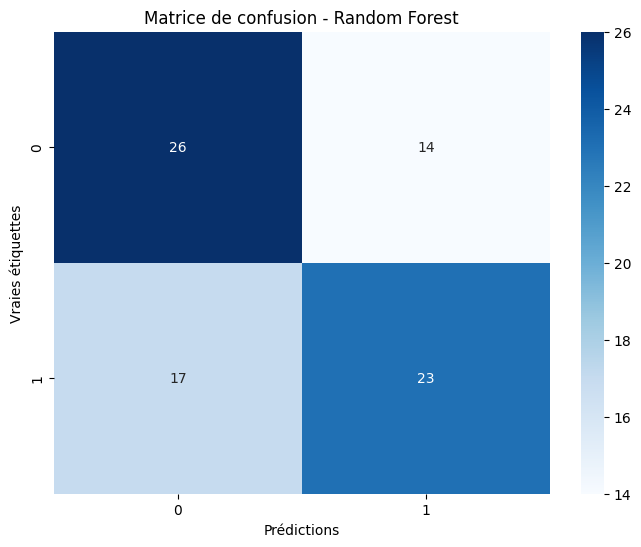

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Créer le modèle Random Forest
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=90, maxDepth=12)

# Entraîner le modèle sur le dataset d'entraînement
print("Entraînement du modèle Random Forest...")
rf_model = rf.fit(train_data)
print("Modèle Random Forest entraîné.")

# Faire des prédictions sur le dataset de test
predictions = rf_model.transform(test_data)

# Afficher quelques prédictions
predictions.select('features', 'label', 'prediction').show(5)

# Calculer plusieurs métriques d'évaluation
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(f"Accuracy: {accuracy}")

# F1-Score
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print(f"F1-Score: {f1_score}")

# Précision (Precision)
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print(f"Précision: {precision}")

# Rappel (Recall)
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print(f"Rappel: {recall}")

# Matrice de confusion
y_true = [int(row['label']) for row in predictions.select('label').collect()]
y_pred = [int(row['prediction']) for row in predictions.select('prediction').collect()]
conf_matrix = confusion_matrix(y_true, y_pred)

# Afficher la matrice de confusion sous forme de tableau
print("Matrice de confusion :")
print(conf_matrix)

# Visualiser la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.title("Matrice de confusion - Random Forest")
plt.ylabel('Vraies étiquettes')
plt.xlabel('Prédictions')
plt.show()


We have very bad model, with very bad results, but the point of this project is to learn how to use mllib in spark. We did two models, random forest and a logistic regression. Then we took the best of the two ones and did more evalutation. If the accuracy and other mesures are pretty bad it is because mllib is does not support ccn models for image processing. We have an accuracy of 0.6125, knowing that if we do a random choice, and it is a binary classification, we will have 50% of accuracy, so our model improve the accuracy only with 10.5%, realy bad.


Confusion matrix:


1.   26: Number of true predictions for class 0 (correctly identified men).
2.   14: Number of false positives for class 0 (women incorrectly identified as men).
3.    14: Number of false positives for class 0 (women incorrectly identified as men).
4.    17: Number of false negatives for class 1 (men incorrectly identified as women).
5.     23: Number of true predictions for class 1 (correctly identified women).









Interpretation:

  The Random Forest model has a slightly balanced performance between the two classes, but with a relatively high error rate:
        It is a little better at predicting men (26 correct out of 40) than women (23 correct out of 40).
        The errors (14 false positives and 17 false negatives) show that the model has difficulty capturing clear distinctions between the two genders, likely due to the limitations of Random Forest for processing images.

In [ ]:
import os
import numpy as np
from PIL import Image
import pandas as pd

# Fonction pour vectoriser une image
def vectorize_image(image_path, size=(50, 50)):
    img = Image.open(image_path).convert('L')  # Convertir en niveaux de gris
    img = img.resize(size)  # Redimensionner l'image
    img_array = np.array(img).flatten()  # Aplatir en vecteur 1D
    return img_array

# Fonction pour charger et vectoriser les images d'un dossier
def process_images_from_folder(folder, label, output_file):
    data = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path) and filename.endswith(('.jpg')):
            # Vectoriser l'image
            img_vector = vectorize_image(img_path)
            # Ajouter à la liste avec l'étiquette
            data.append(img_vector)

    # Sauvegarder dans un fichier CSV
    df = pd.DataFrame(data)
    df.to_csv(output_file, index=False)
    print(f"{label.capitalize()} images vectorisées et sauvegardées dans {output_file}")

# Dossiers source pour les images dans Google Drive
train_men_folder = '/content/gdrive/MyDrive/GenderIsmael/output/train/MEN'
train_women_folder = '/content/gdrive/MyDrive/GenderIsmael/output/train/MEN/WOMAN'

# Sauvegarder les images vectorisées dans des fichiers séparés sur Google Drive
process_images_from_folder(train_men_folder, label='men', output_file='/content/gdrive/MyDrive/abalone/men_images.csv')
process_images_from_folder(train_women_folder, label='women', output_file='/content/gdrive/MyDrive/abalone/women_images.csv')


Men images vectorisées et sauvegardées dans /content/gdrive/MyDrive/abalone/men_images.csv
Women images vectorisées et sauvegardées dans /content/gdrive/MyDrive/abalone/women_images.csv


Here is a "non-important" seccion: we prepare vectorized images to be processed in "Tebleau", the problem is that this software can not treat that many data, here each image is converted to grey and then dimensioned to 50x50. After that we "flat" the image into a 1 dimensional vector, so now we have a one dimensional vector of 2500 values instead of an image (plus one because we add an "m" or a "w" depending on the gender). Of course we lose an incredible part of the information contained in an image. We can'not really do with a better method if we want to use Tableau. And then an other bad point is that we cannot precess more than 700 raws, so less than we have in total: we also lose information in thart way. All that is just for showing how to insert images into "Tableau", but as it is not done for images analysis, we will not go further on this way.

In [ ]:
import os
import numpy as np
from PIL import Image
import pandas as pd

# Fonction pour vectoriser une image
def vectorize_image(image_path, size=(50, 50)):
    img = Image.open(image_path).convert('L')  # Convertir en niveaux de gris
    img = img.resize(size)  # Redimensionner l'image
    img_array = np.array(img).flatten()  # Aplatir en vecteur 1D
    return img_array

# Fonction pour charger et vectoriser les images d'un dossier
def process_images_from_folder(folder, label, max_images=250):
    data = []
    image_count = 0
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path) and filename.endswith(('.jpg', '.jpeg', '.png')):
            # Vectoriser l'image
            img_vector = vectorize_image(img_path)
            # Ajouter à la liste avec l'étiquette (m pour homme, w pour femme)
            data.append([label] + list(img_vector))
            image_count += 1
        # Arrêter une fois que le nombre maximum d'images est atteint
        if image_count >= max_images:
            break
    return data

# Dossiers source pour les images dans Google Drive
train_men_folder = '/content/gdrive/MyDrive/GenderIsmael/output/train/MEN'
train_women_folder = '/content/gdrive/MyDrive/GenderIsmael/output/train/WOMAN'

# Traiter les images d'hommes (label 'm') et femmes (label 'w')
men_data = process_images_from_folder(train_men_folder, label='m', max_images=250)
women_data = process_images_from_folder(train_women_folder, label='w', max_images=250)

# Combiner les deux jeux de données
combined_data = men_data + women_data

# Sauvegarder les images vectorisées dans un seul fichier CSV
df = pd.DataFrame(combined_data)
output_file = '/content/gdrive/MyDrive/abalone/gender_mixed250et50p.csv'
df.to_csv(output_file, index=False)

print(f"Images vectorisées (hommes et femmes) sauvegardées dans {output_file}")


Images vectorisées (hommes et femmes) sauvegardées dans /content/gdrive/MyDrive/abalone/gender_mixed250et50p.csv


#Resign ?


We had very bad results with our models, but we don't resign. I have some ideas to find patterns, let's explore and ask questions to our dataset:


---

Do men or women use more of a specific color ? Do women wear more pink than men for example (caps/huts) ? Or does the makeup do a difference on the presence on some specifc colors ? To resolve this question I will decide about what is pink, I setup like that: all the values between those [199, 21, 133] (RBG) and [255, 228, 225]. Then I get the percentage of thoses values in the picture, if there is more than 7% of pink, we will take the image, verifiy the gender and class them by gender:

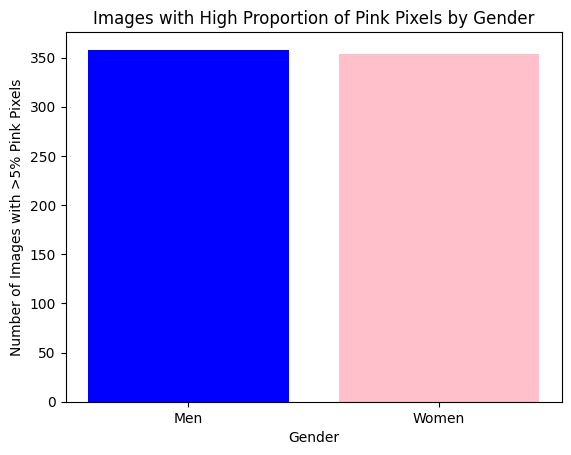

In [ ]:
# @title
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Définir les chemins des répertoires
men_dir = '/content/gdrive/MyDrive/GenderIsmael/output/train/MEN'
women_dir = '/content/gdrive/MyDrive/GenderIsmael/output/train/WOMAN'

# Définir les limites RGB du rose
pink_lower = np.array([199, 21, 133], dtype=np.uint8)
pink_upper = np.array([255, 228, 225], dtype=np.uint8)

# Seuil de proportion de pixels roses
pink_threshold = 0.05

# Initialiser les compteurs
men_count = 0
women_count = 0

# Fonction pour calculer la proportion de pixels roses dans une image
def calculate_pink_proportion(image_path):
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    # Filtrer les pixels dans la fourchette de rose
    pink_pixels = np.sum(
        (image_np[:, :, 0] >= pink_lower[0]) & (image_np[:, :, 0] <= pink_upper[0]) &
        (image_np[:, :, 1] >= pink_lower[1]) & (image_np[:, :, 1] <= pink_upper[1]) &
        (image_np[:, :, 2] >= pink_lower[2]) & (image_np[:, :, 2] <= pink_upper[2])
    )

    # Calculer la proportion
    total_pixels = image_np.shape[0] * image_np.shape[1]
    return pink_pixels / total_pixels

# Analyser les images dans chaque dossier
for image_file in os.listdir(men_dir):
    image_path = os.path.join(men_dir, image_file)
    if os.path.isfile(image_path):
        pink_proportion = calculate_pink_proportion(image_path)
        if pink_proportion > pink_threshold:
            men_count += 1

for image_file in os.listdir(women_dir):
    image_path = os.path.join(women_dir, image_file)
    if os.path.isfile(image_path):
        pink_proportion = calculate_pink_proportion(image_path)
        if pink_proportion > pink_threshold:
            women_count += 1

# Afficher le graphique
categories = ['Men', 'Women']
counts = [men_count, women_count]

plt.bar(categories, counts, color=['blue', 'pink'])
plt.xlabel("Gender")
plt.ylabel("Number of Images with >5% Pink Pixels")
plt.title("Images with High Proportion of Pink Pixels by Gender")
plt.show()


Pink was not relevant, maybe because the color palette is too similar at some colors skin.

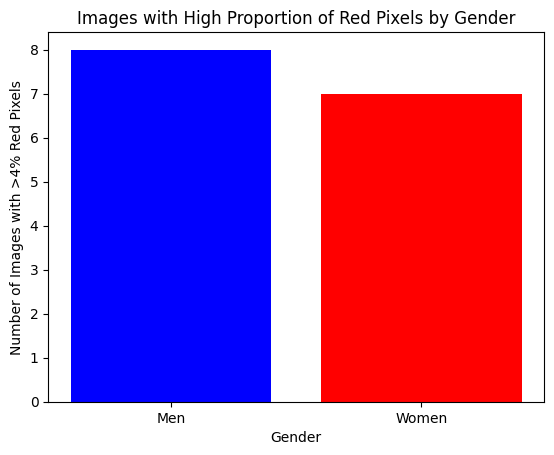

In [ ]:
# @title
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Définir les chemins des répertoires
men_dir = '/content/gdrive/MyDrive/GenderIsmael/output/train/MEN'
women_dir = '/content/gdrive/MyDrive/GenderIsmael/output/train/WOMAN'

# Définir les limites RGB du rouge
red_lower = np.array([150, 0, 0], dtype=np.uint8)  # Bas de la plage pour le rouge
red_upper = np.array([255, 60, 60], dtype=np.uint8)  # Haut de la plage pour le rouge

# Seuil de proportion de pixels rouges
red_threshold = 0.04  # 7% des pixels rouges

# Initialiser les compteurs
men_count = 0
women_count = 0

# Fonction pour calculer la proportion de pixels rouges dans une image
def calculate_red_proportion(image_path):
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    # Filtrer les pixels dans la fourchette de rouge
    red_pixels = np.sum(
        (image_np[:, :, 0] >= red_lower[0]) & (image_np[:, :, 0] <= red_upper[0]) &
        (image_np[:, :, 1] >= red_lower[1]) & (image_np[:, :, 1] <= red_upper[1]) &
        (image_np[:, :, 2] >= red_lower[2]) & (image_np[:, :, 2] <= red_upper[2])
    )

    # Calculer la proportion
    total_pixels = image_np.shape[0] * image_np.shape[1]
    return red_pixels / total_pixels

# Analyser les images dans chaque dossier
for image_file in os.listdir(men_dir):
    image_path = os.path.join(men_dir, image_file)
    if os.path.isfile(image_path):
        red_proportion = calculate_red_proportion(image_path)
        if red_proportion > red_threshold:
            men_count += 1

for image_file in os.listdir(women_dir):
    image_path = os.path.join(women_dir, image_file)
    if os.path.isfile(image_path):
        red_proportion = calculate_red_proportion(image_path)
        if red_proportion > red_threshold:
            women_count += 1

# Afficher le graphique
categories = ['Men', 'Women']
counts = [men_count, women_count]

plt.bar(categories, counts, color=['blue', 'red'])  # Couleur rouge pour Women
plt.xlabel("Gender")
plt.ylabel("Number of Images with >4% Red Pixels")
plt.title("Images with High Proportion of Red Pixels by Gender")
plt.show()


This is a suprise. By instinct we could guess that because of the red lips, the proportion of red could be bigger between the Woman, unfortunnatelly for my projet it is not the case. Since here we will try some random colors waiting for a miracle.


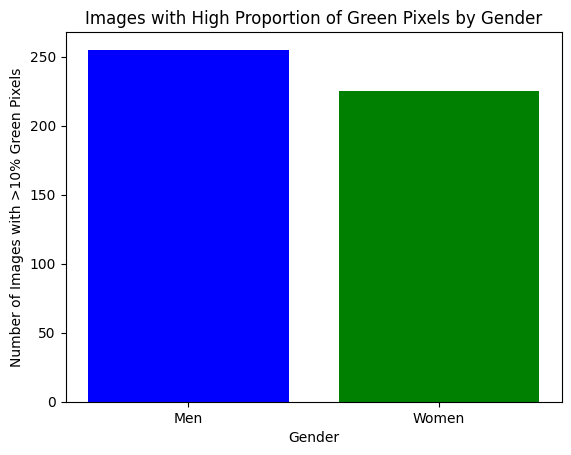

In [ ]:
# @title
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Chemins des répertoires
men_dir = '/content/gdrive/MyDrive/GenderIsmael/output/train/MEN'
women_dir = '/content/gdrive/MyDrive/GenderIsmael/output/train/WOMAN'

# Limites RGB pour la couleur verte (du vert foncé au vert clair)
green_lower = np.array([0, 100, 0], dtype=np.uint8)      # Vert foncé
green_upper = np.array([144, 238, 144], dtype=np.uint8)  # Vert clair

# Seuil de proportion de pixels verts
green_threshold = 0.05

# Initialiser les compteurs
men_count = 0
women_count = 0

# Fonction pour calculer la proportion de pixels verts dans une image
def calculate_green_proportion(image_path):
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    # Filtrer les pixels dans la fourchette de vert
    green_pixels = np.sum(
        (image_np[:, :, 0] >= green_lower[0]) & (image_np[:, :, 0] <= green_upper[0]) &
        (image_np[:, :, 1] >= green_lower[1]) & (image_np[:, :, 1] <= green_upper[1]) &
        (image_np[:, :, 2] >= green_lower[2]) & (image_np[:, :, 2] <= green_upper[2])
    )

    # Calculer la proportion
    total_pixels = image_np.shape[0] * image_np.shape[1]
    return green_pixels / total_pixels

# Analyser les images dans chaque dossier
for image_file in os.listdir(men_dir):
    image_path = os.path.join(men_dir, image_file)
    if os.path.isfile(image_path):
        green_proportion = calculate_green_proportion(image_path)
        if green_proportion > green_threshold:
            men_count += 1

for image_file in os.listdir(women_dir):
    image_path = os.path.join(women_dir, image_file)
    if os.path.isfile(image_path):
        green_proportion = calculate_green_proportion(image_path)
        if green_proportion > green_threshold:
            women_count += 1

# Afficher le graphique
categories = ['Men', 'Women']
counts = [men_count, women_count]
plt.bar(categories, counts, color=['blue', 'green'])
plt.xlabel("Gender")
plt.ylabel("Number of Images with >10% Green Pixels")
plt.title("Images with High Proportion of Green Pixels by Gender")
plt.show()


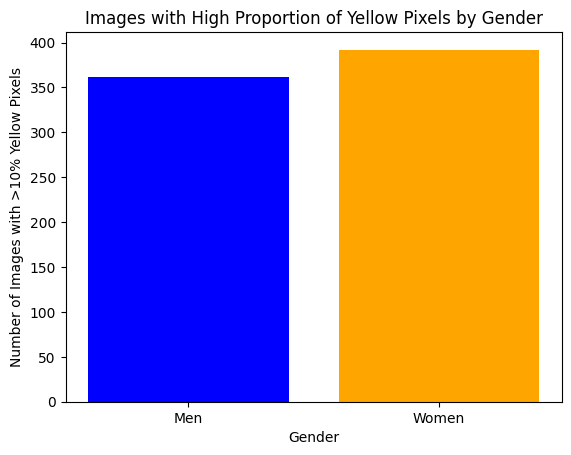

In [ ]:
# @title
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Chemins des répertoires
men_dir = '/content/gdrive/MyDrive/GenderIsmael/output/train/MEN'
women_dir = '/content/gdrive/MyDrive/GenderIsmael/output/train/WOMAN'

# Limites RGB pour la couleur jaune (du jaune foncé au jaune clair)
yellow_lower = np.array([128, 128, 0], dtype=np.uint8)   # Jaune foncé
yellow_upper = np.array([255, 255, 153], dtype=np.uint8) # Jaune clair

# Seuil de proportion de pixels jaunes
yellow_threshold = 0.10

# Initialiser les compteurs
men_count = 0
women_count = 0

# Fonction pour calculer la proportion de pixels jaunes dans une image
def calculate_yellow_proportion(image_path):
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    # Filtrer les pixels dans la fourchette de jaune
    yellow_pixels = np.sum(
        (image_np[:, :, 0] >= yellow_lower[0]) & (image_np[:, :, 0] <= yellow_upper[0]) &
        (image_np[:, :, 1] >= yellow_lower[1]) & (image_np[:, :, 1] <= yellow_upper[1]) &
        (image_np[:, :, 2] >= yellow_lower[2]) & (image_np[:, :, 2] <= yellow_upper[2])
    )

    # Calculer la proportion
    total_pixels = image_np.shape[0] * image_np.shape[1]
    return yellow_pixels / total_pixels

# Analyser les images dans chaque dossier
for image_file in os.listdir(men_dir):
    image_path = os.path.join(men_dir, image_file)
    if os.path.isfile(image_path):
        yellow_proportion = calculate_yellow_proportion(image_path)
        if yellow_proportion > yellow_threshold:
            men_count += 1

for image_file in os.listdir(women_dir):
    image_path = os.path.join(women_dir, image_file)
    if os.path.isfile(image_path):
        yellow_proportion = calculate_yellow_proportion(image_path)
        if yellow_proportion > yellow_threshold:
            women_count += 1

# Afficher le graphique
categories = ['Men', 'Women']
counts = [men_count, women_count]
plt.bar(categories, counts, color=['blue', 'orange'])
plt.xlabel("Gender")
plt.ylabel("Number of Images with >10% Yellow Pixels")
plt.title("Images with High Proportion of Yellow Pixels by Gender")
plt.show()

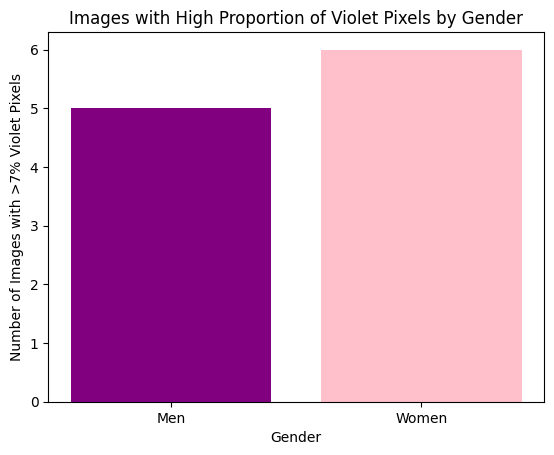

In [ ]:
# @title
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Chemins des répertoires
men_dir = '/content/gdrive/MyDrive/GenderIsmael/output/train/MEN'
women_dir = '/content/gdrive/MyDrive/GenderIsmael/output/train/WOMAN'

# Limites RGB pour la couleur violette (du violet foncé au violet clair)
violet_lower = np.array([75, 0, 130], dtype=np.uint8)   # Violet foncé
violet_upper = np.array([238, 130, 238], dtype=np.uint8) # Violet clair

# Seuil de proportion de pixels violets
violet_threshold = 0.07

# Initialiser les compteurs
men_count = 0
women_count = 0

# Fonction pour calculer la proportion de pixels violets dans une image
def calculate_violet_proportion(image_path):
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    # Filtrer les pixels dans la fourchette de violet
    violet_pixels = np.sum(
        (image_np[:, :, 0] >= violet_lower[0]) & (image_np[:, :, 0] <= violet_upper[0]) &
        (image_np[:, :, 1] >= violet_lower[1]) & (image_np[:, :, 1] <= violet_upper[1]) &
        (image_np[:, :, 2] >= violet_lower[2]) & (image_np[:, :, 2] <= violet_upper[2])
    )

    # Calculer la proportion
    total_pixels = image_np.shape[0] * image_np.shape[1]
    return violet_pixels / total_pixels

# Analyser les images dans chaque dossier
for image_file in os.listdir(men_dir):
    image_path = os.path.join(men_dir, image_file)
    if os.path.isfile(image_path):
        violet_proportion = calculate_violet_proportion(image_path)
        if violet_proportion > violet_threshold:
            men_count += 1

for image_file in os.listdir(women_dir):
    image_path = os.path.join(women_dir, image_file)
    if os.path.isfile(image_path):
        violet_proportion = calculate_violet_proportion(image_path)
        if violet_proportion > violet_threshold:
            women_count += 1

# Afficher le graphique
categories = ['Men', 'Women']
counts = [men_count, women_count]
plt.bar(categories, counts, color=['purple', 'pink'])
plt.xlabel("Gender")
plt.ylabel("Number of Images with >7% Violet Pixels")
plt.title("Images with High Proportion of Violet Pixels by Gender")
plt.show()


Unfortunately, comparing the presence was not enough relevant. I was really waiting for some good results. But I did not said my last word. Usually, woman use more makeup, yes, and also more filters on pictures right ? This change something on the colors: THE VARIANCE. The makeup and filter are used to hide imperfections, and those usually are defined by a contraste of colors, like a scar, acne pimple or mole. In the first graph we see the average RGB variance, in the central square of 9x9 pixels. Then on the second, we do the same thing but on the entire picture.

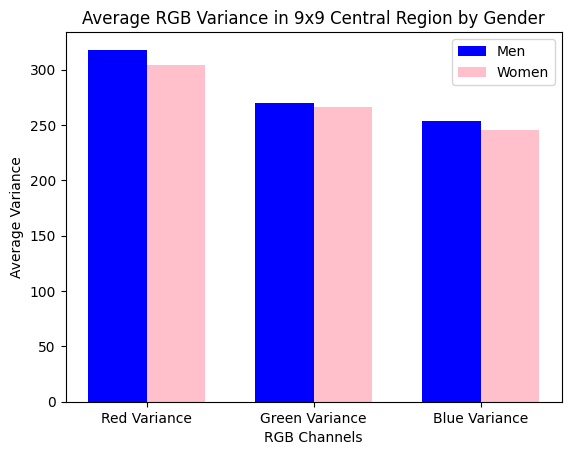

In [ ]:
# @title
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Chemins des répertoires
men_dir = '/content/gdrive/MyDrive/GenderIsmael/output/train/MEN'
women_dir = '/content/gdrive/MyDrive/GenderIsmael/output/train/WOMAN'

# Fonction pour calculer la variance des couleurs RGB au centre de l'image
def calculate_rgb_variance(image_path):
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    # Calcul des coordonnées pour le carré central de 9x9 pixels
    center_x, center_y = image_np.shape[1] // 2, image_np.shape[0] // 2
    half_size = 4  # 9x9 pixels signifie 4 pixels de chaque côté du centre

    # Extraire la région 9x9 centrale
    central_square = image_np[center_y - half_size:center_y + half_size + 1,
                              center_x - half_size:center_x + half_size + 1]

    # Calculer la variance pour chaque canal RGB
    variances = np.var(central_square, axis=(0, 1))
    return variances

# Variables pour stocker les variances pour chaque genre
men_variances = []
women_variances = []

# Analyser les images des hommes
for image_file in os.listdir(men_dir):
    image_path = os.path.join(men_dir, image_file)
    if os.path.isfile(image_path):
        variances = calculate_rgb_variance(image_path)
        men_variances.append(variances)

# Analyser les images des femmes
for image_file in os.listdir(women_dir):
    image_path = os.path.join(women_dir, image_file)
    if os.path.isfile(image_path):
        variances = calculate_rgb_variance(image_path)
        women_variances.append(variances)

# Calculer la moyenne de la variance pour chaque canal RGB pour chaque genre
mean_variance_men = np.mean(men_variances, axis=0)
mean_variance_women = np.mean(women_variances, axis=0)

# Préparer les données pour le graphique
labels = ['Red Variance', 'Green Variance', 'Blue Variance']
men_means = mean_variance_men
women_means = mean_variance_women

# Afficher le graphique
x = np.arange(len(labels))  # Position des labels
width = 0.35  # Largeur des barres

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, men_means, width, label='Men', color='blue')
bars2 = ax.bar(x + width/2, women_means, width, label='Women', color='pink')

# Ajouter les labels et titre
ax.set_xlabel('RGB Channels')
ax.set_ylabel('Average Variance')
ax.set_title('Average RGB Variance in 9x9 Central Region by Gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Afficher le graphique
plt.show()


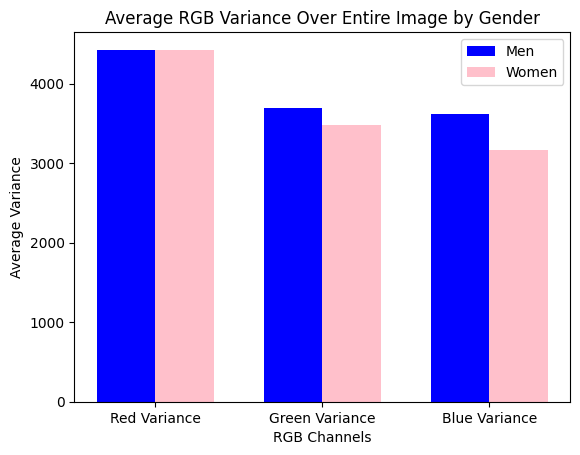

In [ ]:
# @title
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Chemins des répertoires
men_dir = '/content/gdrive/MyDrive/GenderIsmael/output/train/MEN'
women_dir = '/content/gdrive/MyDrive/GenderIsmael/output/train/WOMAN'

# Fonction pour calculer la variance des couleurs RGB sur toute l'image
def calculate_rgb_variance(image_path):
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)

    # Calculer la variance pour chaque canal RGB sur toute l'image
    variances = np.var(image_np, axis=(0, 1))  # Variance pour chaque canal (R, G, B)
    return variances

# Variables pour stocker les variances pour chaque genre
men_variances = []
women_variances = []

# Analyser les images des hommes
for image_file in os.listdir(men_dir):
    image_path = os.path.join(men_dir, image_file)
    if os.path.isfile(image_path):
        variances = calculate_rgb_variance(image_path)
        men_variances.append(variances)

# Analyser les images des femmes
for image_file in os.listdir(women_dir):
    image_path = os.path.join(women_dir, image_file)
    if os.path.isfile(image_path):
        variances = calculate_rgb_variance(image_path)
        women_variances.append(variances)

# Calculer la moyenne de la variance pour chaque canal RGB pour chaque genre
mean_variance_men = np.mean(men_variances, axis=0)
mean_variance_women = np.mean(women_variances, axis=0)

# Préparer les données pour le graphique
labels = ['Red Variance', 'Green Variance', 'Blue Variance']
men_means = mean_variance_men
women_means = mean_variance_women

# Afficher le graphique
x = np.arange(len(labels))  # Position des labels
width = 0.35  # Largeur des barres

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, men_means, width, label='Men', color='blue')
bars2 = ax.bar(x + width/2, women_means, width, label='Women', color='pink')

# Ajouter les labels et titre
ax.set_xlabel('RGB Channels')
ax.set_ylabel('Average Variance')
ax.set_title('Average RGB Variance Over Entire Image by Gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Afficher le graphique
plt.show()


Now we have something relevant. As predicted colors variance on men are higher, and the blue one is the most notable. We have something like 3500 variance on average for men and 3100 for woman. Now we can try to compete with the previous models, I setup the code like that:


*   if blue varianceis higher than 3500, we predict a man
*   else if blue variance is lower than 3300, we predict a woman
*  And if the variance is between the two threshold, we sort it.




In [ ]:
# @title
import random

# Seuils pour la variance du canal bleu
blue_variance_lower_threshold = 3300
blue_variance_upper_threshold = 3500

# Variables pour stocker les prédictions et les étiquettes réelles
true_labels = []  # 1 pour homme, 0 pour femme
predicted_labels = []

# Prédictions pour les hommes (étiquette réelle = 1)
for image_file in os.listdir(men_dir):
    image_path = os.path.join(men_dir, image_file)
    if os.path.isfile(image_path):
        variances = calculate_rgb_variance(image_path)
        true_labels.append(1)  # Homme
        # Prédiction basée sur la variance du bleu
        if variances[2] < blue_variance_lower_threshold:
            predicted_labels.append(0)  # Femme
        elif variances[2] > blue_variance_upper_threshold:
            predicted_labels.append(1)  # Homme
        else:
            predicted_labels.append(random.choice([0, 1]))  # Tirage au sort

# Prédictions pour les femmes (étiquette réelle = 0)
for image_file in os.listdir(women_dir):
    image_path = os.path.join(women_dir, image_file)
    if os.path.isfile(image_path):
        variances = calculate_rgb_variance(image_path)
        true_labels.append(0)  # Femme
        # Prédiction basée sur la variance du bleu
        if variances[2] < blue_variance_lower_threshold:
            predicted_labels.append(0)  # Femme
        elif variances[2] > blue_variance_upper_threshold:
            predicted_labels.append(1)  # Homme
        else:
            predicted_labels.append(random.choice([0, 1]))  # Tirage au sort

# Calculer l'accuracy
correct_predictions = sum([1 for true, pred in zip(true_labels, predicted_labels) if true == pred])
accuracy = correct_predictions / len(true_labels)

# Afficher le résultat
print(f"Accuracy based en blue variance : {accuracy * 100:.2f}%")

Accuracy based en blue variance : 50.48%


After to try many and many different threshols, I any of them gave me a good accuracy. We tried everything but could'nt made a relevant model. Next projext we will use a more adequate model for our datasets.


---
#Conclusion

This project explored gender recognition from images using basic models available in MLlib, despite the inherent limitations for image processing tasks.
Challenge we went thru:

*   The primary challenge was using non-CNN models, which lack the ability to learn spatial relationships in images, essential for such classification tasks.
*   Simplistic thresholds for color or variance analysis did not yield robust decision-making metrics.



 Although the models' performance was suboptimal, the project successfully demonstrated data preprocessing, visualization, and basic model implementation using PySpark. It highlights the importance of understanding both data and tools to make informed decisions in machine learning projects.


